In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Set a random seed for reproducibility
torch.manual_seed(42)

In [13]:
from differential_model import *
from generate_data import *
from physical_model import *
from plot import *

In [14]:
device = torch.device("cpu")
print("No GPU available, using CPU.")


No GPU available, using CPU.


In [15]:
# System parameters
m = 1.0  # mass
c = 0.2  # damping coefficient
k = 100.0  # spring constant

# Time
t0 = 0
tf = 10

# Frequncy
fs = 50

# tspan
tspan = torch.arange(t0, tf, 1/fs)
nt = tf * fs

In [16]:
# Initialize the Spring_Model on the GPU
spring_model_gt = Spring_Model(m, c, k, t0, tf, fs, device, [1000, 3, 0, 2, 0])
simulator = Linear_Spring_Model(m, c, k, t0, tf, fs, device)

In [17]:
sig_u = [1, 3, 5]
data_gt = torch.zeros(nt, len(sig_u), 2)
data_simulated = torch.zeros(nt, len(sig_u), 2)
u_data = torch.zeros(nt, len(sig_u))

for i in range(len(sig_u)):
    u = generate_u(sig_u[i], nt, fs, device)
    data_gt[:, i, :] = generate_date(spring_model_gt, u).T
    data_simulated[:, i, :] = generate_date(simulator, u).T
    u_data[:, i] = u


In [18]:
initial_error = torch.mean((data_gt -data_simulated) ** 2)
initial_error

tensor(0.8543)

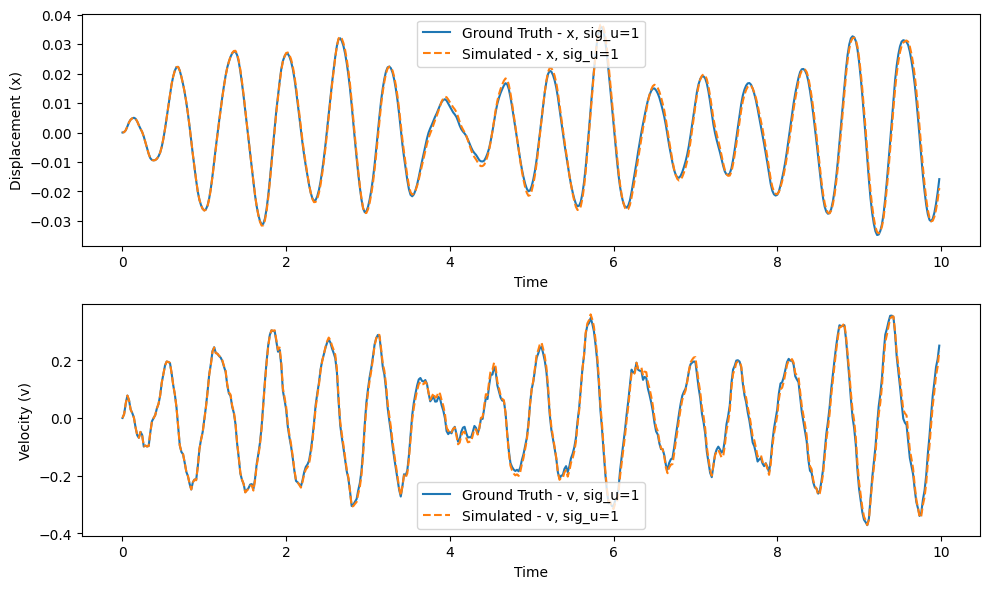

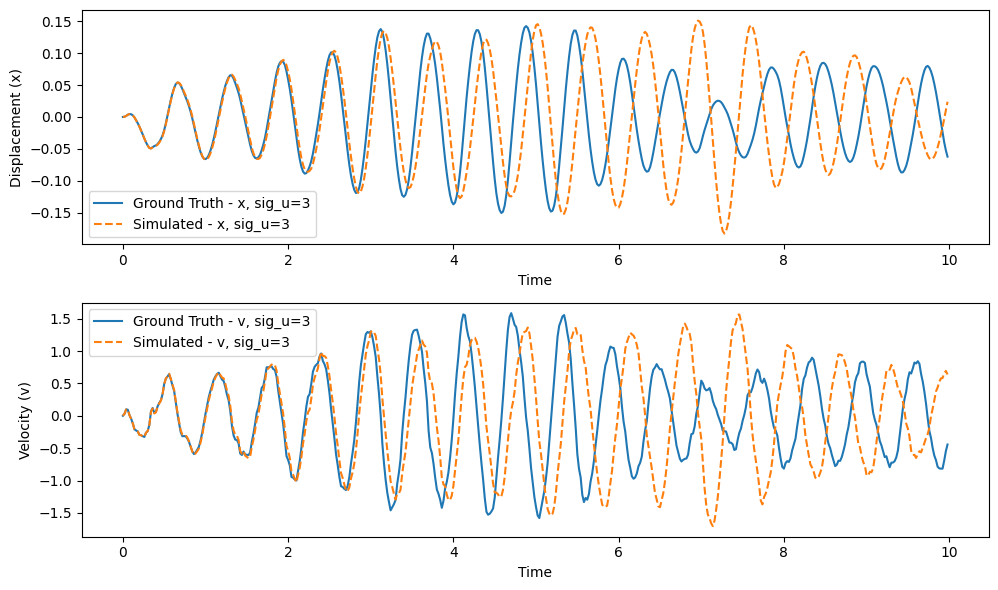

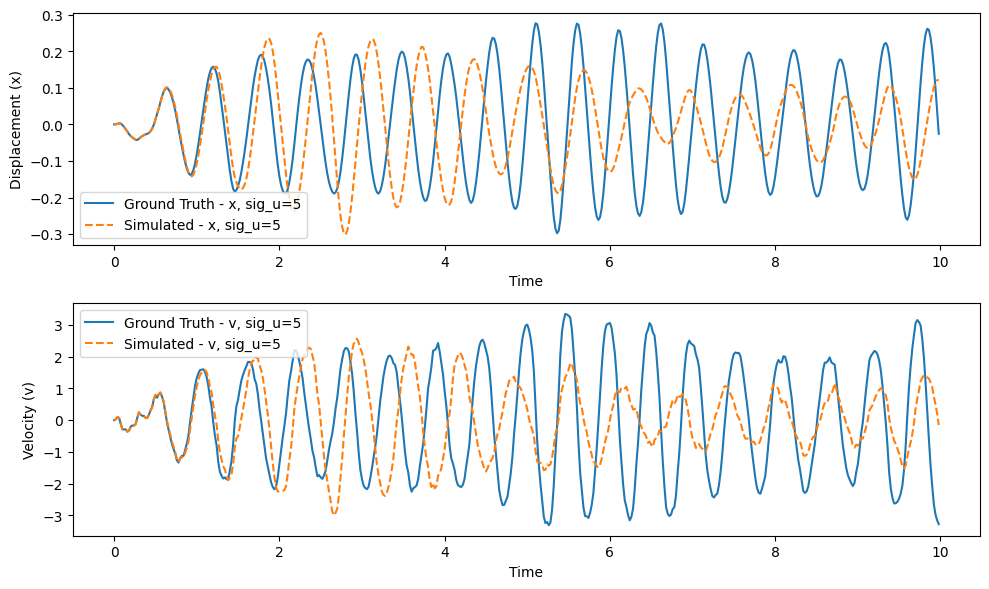

In [19]:
# Plotting
time_values = tspan.squeeze().cpu().numpy()

for i in range(len(sig_u)):
    plt.figure(figsize=(10, 6))

    # Plotting Ground Truth and Simulated Data for 'x'
    plt.subplot(2, 1, 1)
    plt.plot(time_values, data_gt[:, i, 0], label=f'Ground Truth - x, sig_u={sig_u[i]}')
    plt.plot(time_values, data_simulated[:, i, 0], label=f'Simulated - x, sig_u={sig_u[i]}', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Displacement (x)')
    plt.legend()

    # Plotting Ground Truth and Simulated Data for 'v'
    plt.subplot(2, 1, 2)
    plt.plot(time_values, data_gt[:, i, 1], label=f'Ground Truth - v, sig_u={sig_u[i]}')
    plt.plot(time_values, data_simulated[:, i, 1], label=f'Simulated - v, sig_u={sig_u[i]}', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Velocity (v)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [29]:
class DifferentialSolver:
    def __init__(self, model, optimizer, criterion=nn.MSELoss()):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    def train(self, simulation, target_solution, u, max_epochs=100, msteps=2, batch_size=1000):
        display_at = max(1, max_epochs / 20)
        losses = []
        N = target_solution.shape[0]
        feasible_range = N - msteps - 1
        std_data = torch.std(target_solution, axis = 0).T    #torch.Size([2, 5])
        best_model = self.model
        min_loss = 10

        for sim in range(max_epochs):
            self.optimizer.zero_grad()
            loss = 0

            for batch in range(batch_size):
                r = np.random.randint(feasible_range)
                yi = target_solution[r, :].T # torch.Size([2, 5])

                for m in range(msteps):
                    u_m = u[r + m: r + m + 1, :] # torch.Size([1, 5])
                    yi = simulation.step(yi, u_m)
                    input = torch.cat([u_m, yi], axis=0).T  # Concatenate k and yi.T
                    epsilon = self.model(input).T # torch.Size([2, 5])
                    dy_i = simulation.step_model(epsilon)
                    yi = yi + dy_i
                    loss += self.criterion(yi.div(std_data) , target_solution[r + m + 1, :].T.div(std_data)) / msteps

            loss /= batch_size
            loss.backward(retain_graph=True)
            self.optimizer.step()
            losses.append(loss.item())

            if loss.item() < min_loss:
                min_loss = loss.item()
                best_model = self.model

            if sim % display_at == 0:
                print(sim, "Training Loss:", loss.item())
        self.model = best_model
        
        return losses

In [40]:
# Create a neural network model
model = NeuralNet(3, [16, 32, 16], 1, nn.ReLU(), device)
model.load_state_dict(torch.load('linear_model_epsilon_parameters_m1.pth'))
# Create a DifferentialSolver and train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
solver = DifferentialSolver(model, optimizer)

0 Training Loss: 0.0010879470501095057
25 Training Loss: 0.000948623230215162
50 Training Loss: 0.0005927328602410853
75 Training Loss: 0.00024446789757348597
100 Training Loss: 7.956711488077417e-05
125 Training Loss: 3.468729119049385e-05
150 Training Loss: 1.495746346336091e-05
175 Training Loss: 2.2586364138987847e-05
200 Training Loss: 9.758843589224853e-06
225 Training Loss: 7.903360710770357e-06
250 Training Loss: 4.789326794707449e-06
275 Training Loss: 4.442045792529825e-06
300 Training Loss: 3.5372088404983515e-06
325 Training Loss: 4.1592470552132e-06
350 Training Loss: 3.949321580876131e-06
375 Training Loss: 3.7480806440726155e-06
400 Training Loss: 3.7912266179773724e-06
425 Training Loss: 2.341468643862754e-06
450 Training Loss: 3.0363867153937463e-06
475 Training Loss: 2.3706734282313846e-06


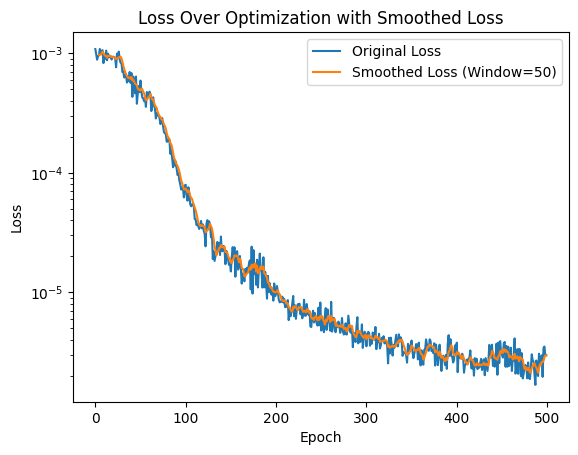

In [31]:
losses = solver.train(simulator, target_solution=data_gt, u = u_data, max_epochs=500, msteps=1, batch_size=500)
plot_losses(losses, 5)

In [41]:
data_simulated_NN = torch.zeros(nt, len(sig_u), 2)
yi = data_simulated_NN[0, :].T

for m in range(nt - 1):
    u_m = u_data[m : m + 1, :] # torch.Size([1, 5])
    yi = simulator.step(yi, u_m)
    input = torch.cat([u_m, yi], axis=0).T  # Concatenate k and yi.T
    epsilon = solver.model(input).T # torch.Size([2, 5])
    dy_i = simulator.step_model(epsilon=epsilon)
    yi = yi + dy_i
    data_simulated_NN[m + 1, :] = yi.T

final_error = torch.mean((data_gt -data_simulated_NN) ** 2)
final_error

tensor(0.1125, grad_fn=<MeanBackward0>)

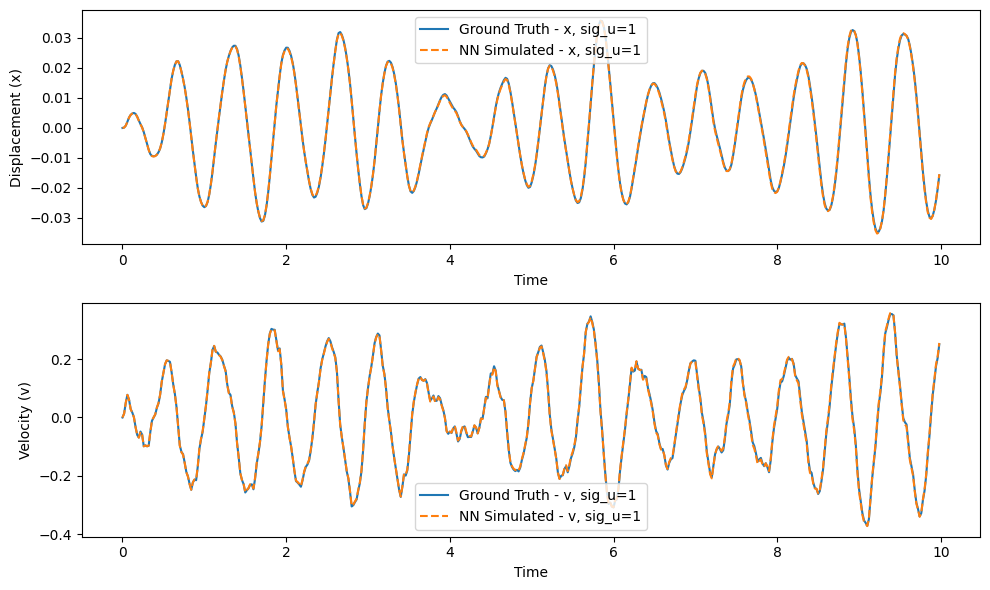

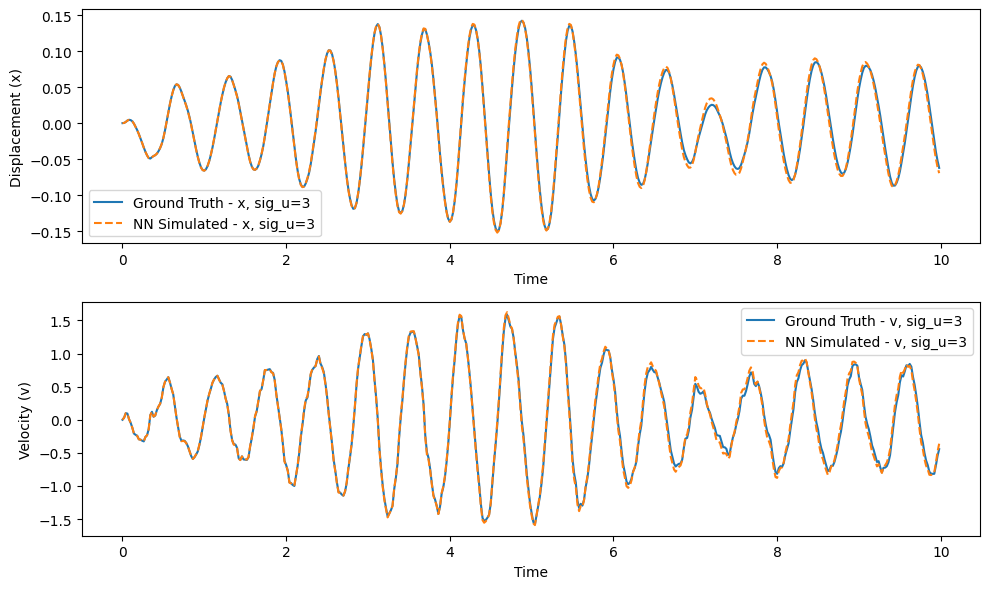

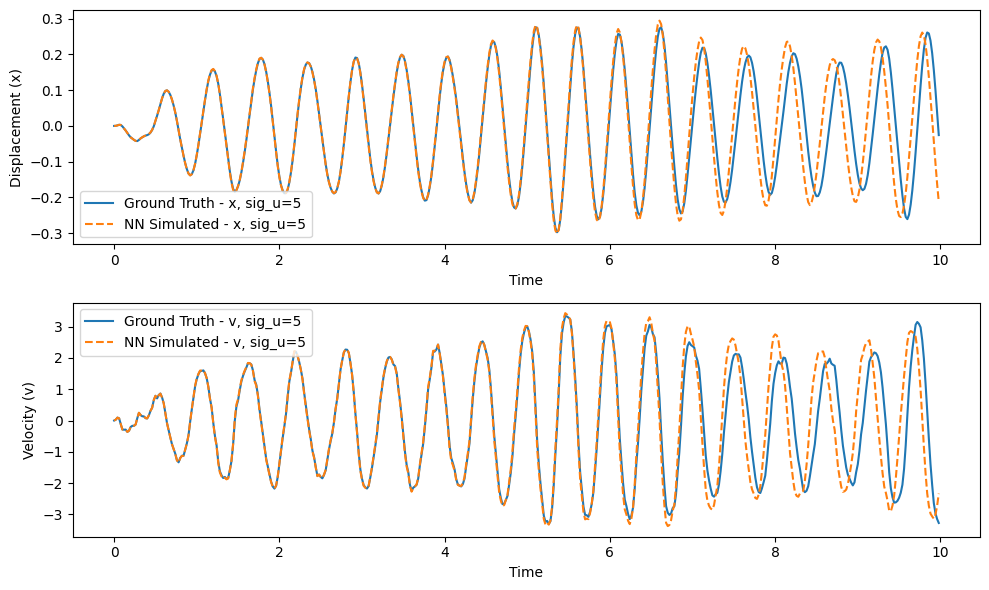

In [42]:
# Plotting
time_values = tspan.squeeze().cpu().numpy()

for i in range(len(sig_u)):
    plt.figure(figsize=(10, 6))

    # Plotting Ground Truth and Simulated Data for 'x'
    plt.subplot(2, 1, 1)
    plt.plot(time_values, data_gt[:, i, 0], label=f'Ground Truth - x, sig_u={sig_u[i]}')
    # plt.plot(time_values, data_simulated[:, i, 0], label=f'Simulated - x, sig_u={sig_u[i]}', linestyle='dashed')
    plt.plot(time_values, data_simulated_NN.detach().numpy()[:, i, 0], label=f'NN Simulated - x, sig_u={sig_u[i]}', linestyle='dashed')

    plt.xlabel('Time')
    plt.ylabel('Displacement (x)')
    plt.legend()

    # Plotting Ground Truth and Simulated Data for 'v'
    plt.subplot(2, 1, 2)
    plt.plot(time_values, data_gt[:, i, 1], label=f'Ground Truth - v, sig_u={sig_u[i]}')
    # plt.plot(time_values, data_simulated[:, i, 1], label=f'Simulated - v, sig_u={sig_u[i]}', linestyle='dashed')
    plt.plot(time_values, data_simulated_NN.detach().numpy()[:, i, 1], label=f'NN Simulated - v, sig_u={sig_u[i]}', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Velocity (v)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [35]:
sig_u_test = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.4, 6, 6.5, 7]
data_gt_test = torch.zeros(nt, len(sig_u_test), 2)
data_simulated_test = torch.zeros(nt, len(sig_u_test), 2)
data_simulated_NN_test = torch.zeros(nt, len(sig_u_test), 2)
u_data_test = torch.zeros(nt, len(sig_u_test))

for i in range(len(sig_u_test)):
    u = generate_u(sig_u_test[i], nt, fs, device)
    data_gt_test[:, i, :] = generate_date(spring_model_gt, u).T
    data_simulated_test[:, i, :] = generate_date(simulator, u).T
    u_data_test[:, i] = u

yi = data_simulated_NN_test[0, :].T
for m in range(nt - 1):
    u_m = u_data_test[m : m + 1, :] # torch.Size([1, 5])
    yi = simulator.step(yi, u_m)
    input = torch.cat([u_m, yi], axis=0).T  # Concatenate k and yi.T
    epsilon = solver.model(input).T # torch.Size([2, 5])
    dy_i = simulator.step_model(epsilon=epsilon)
    yi = yi + dy_i
    data_simulated_NN_test[m + 1, :] = yi.T

In [36]:
initial_error_test = torch.mean((data_gt_test -data_simulated_test) ** 2)
final_error_test = torch.mean((data_gt_test -data_simulated_NN_test) ** 2)
initial_error_test, final_error_test

(tensor(0.2519), tensor(0.0033, grad_fn=<MeanBackward0>))

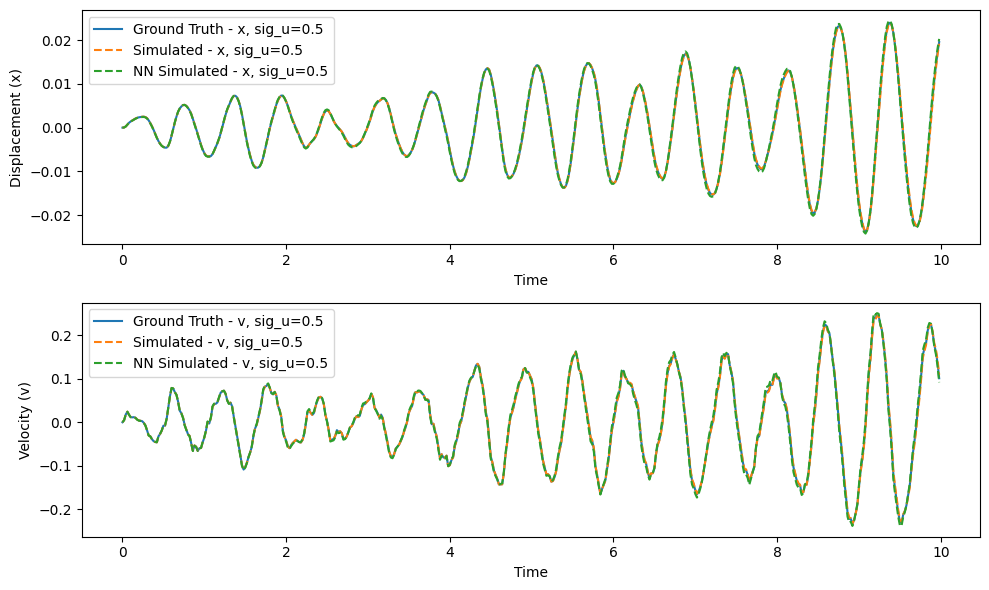

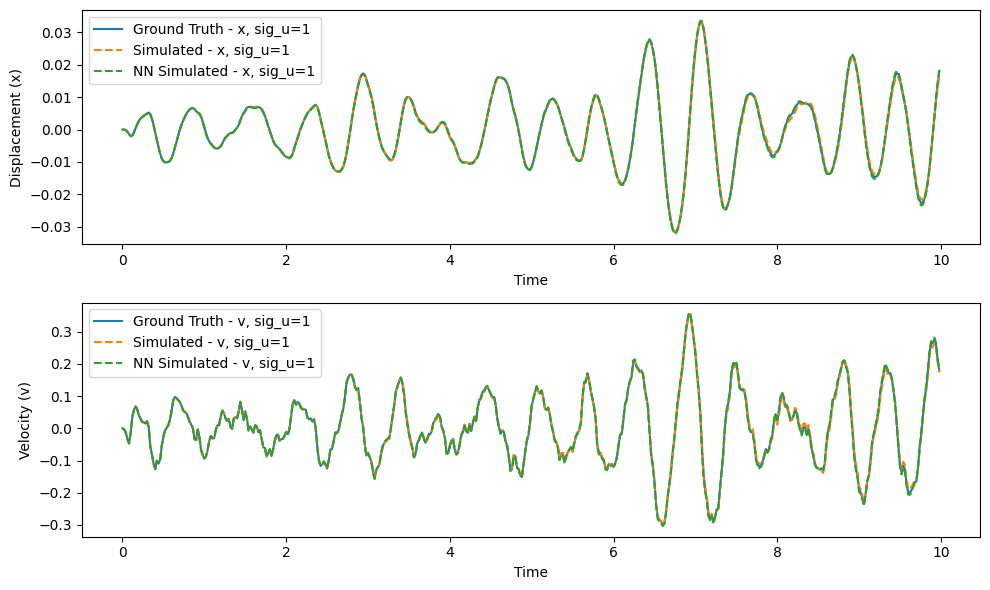

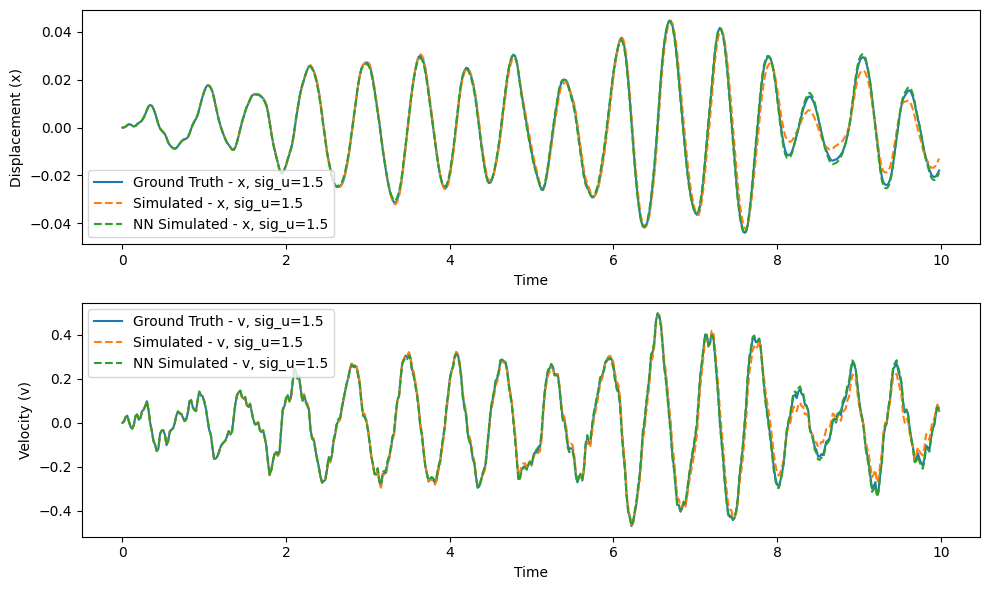

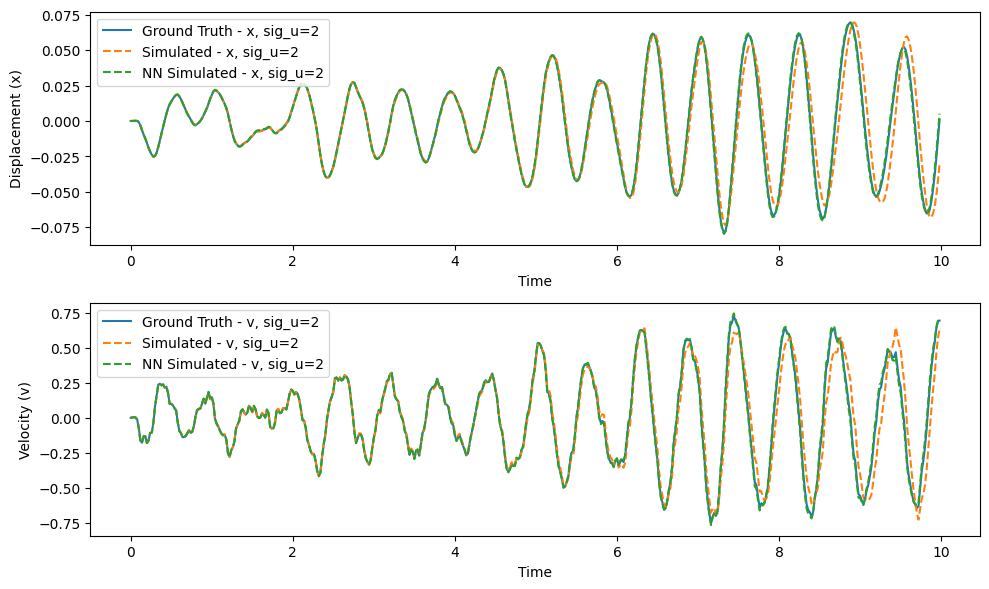

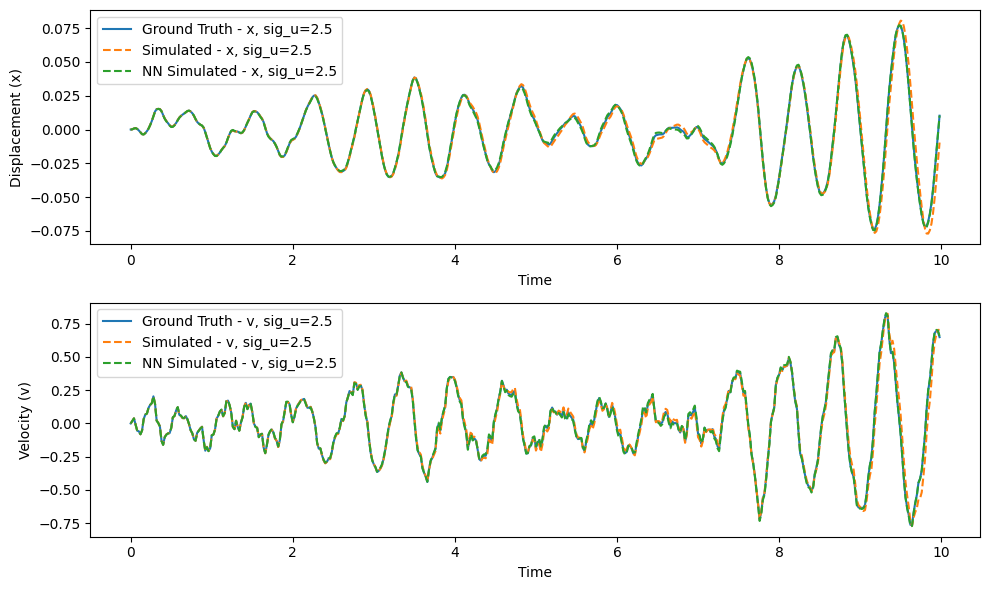

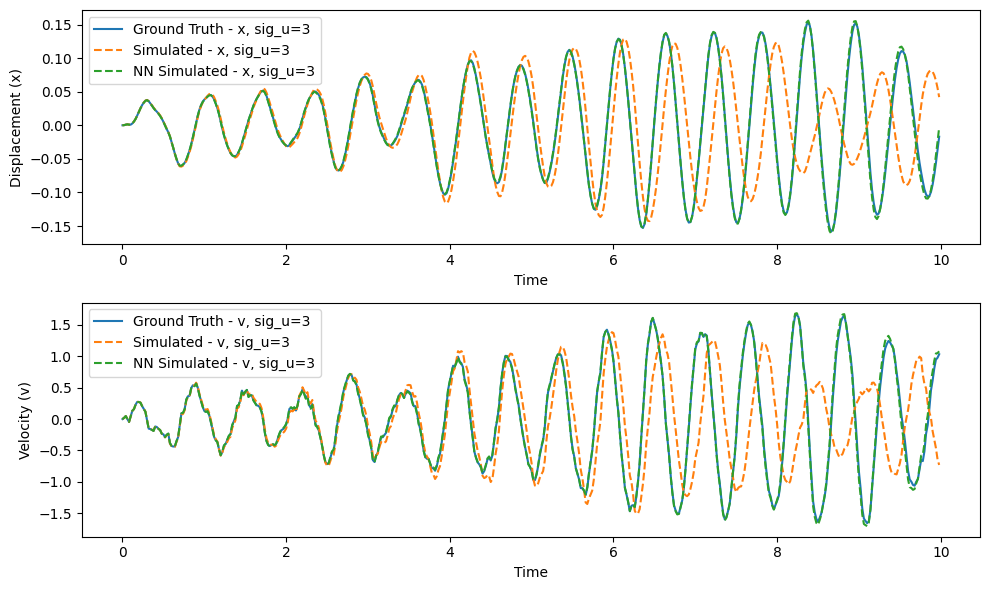

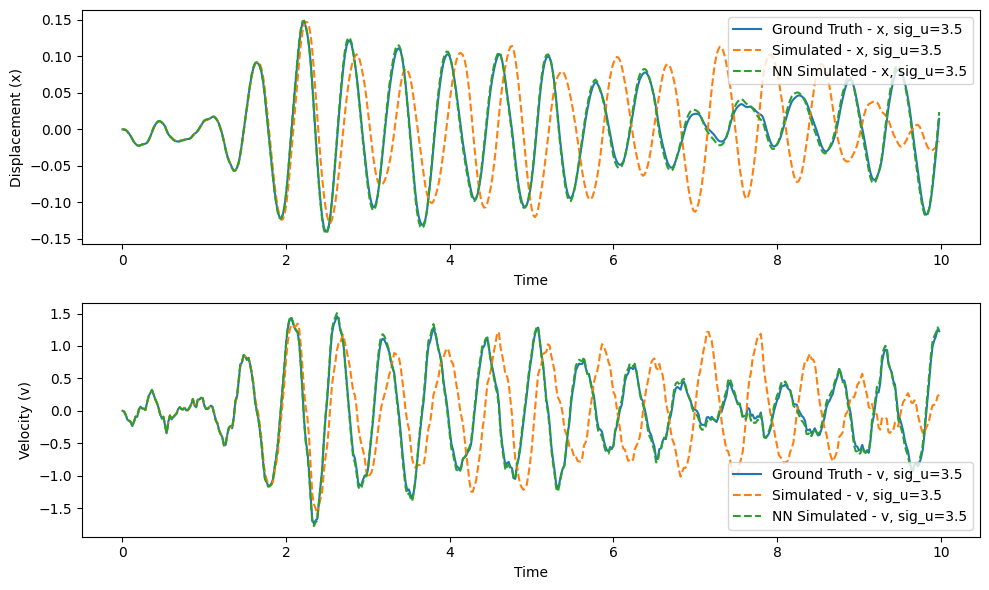

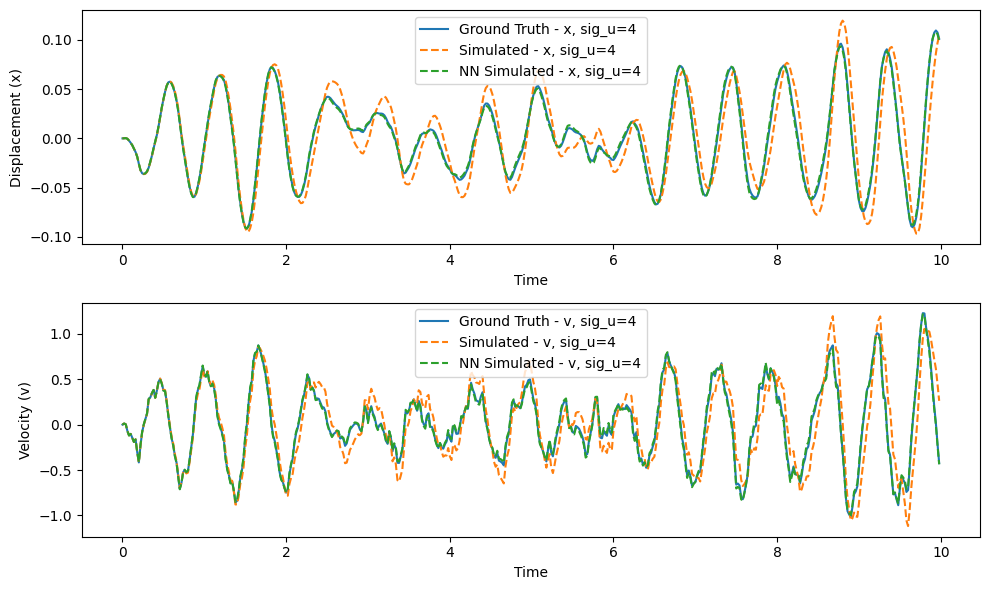

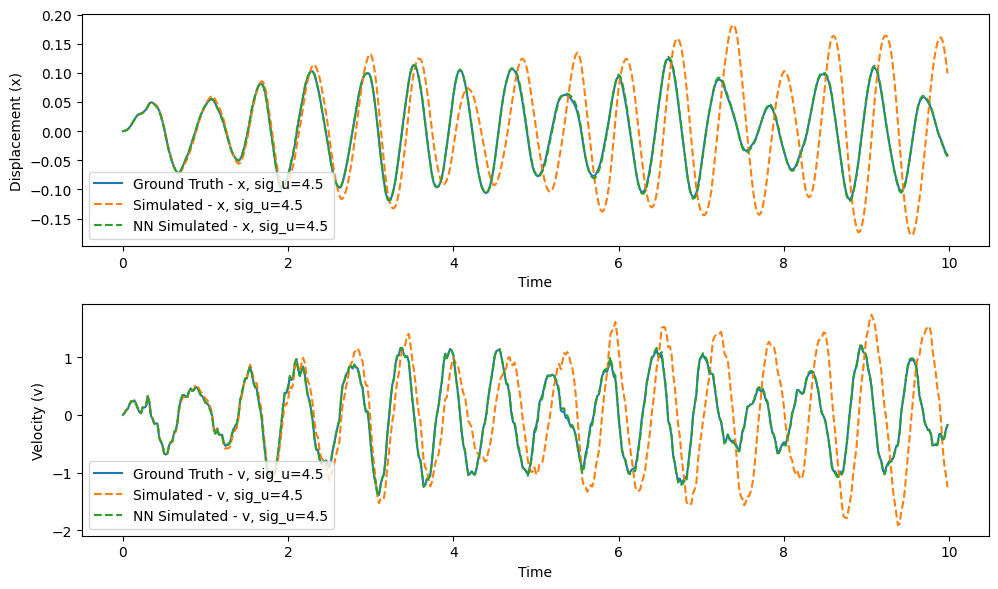

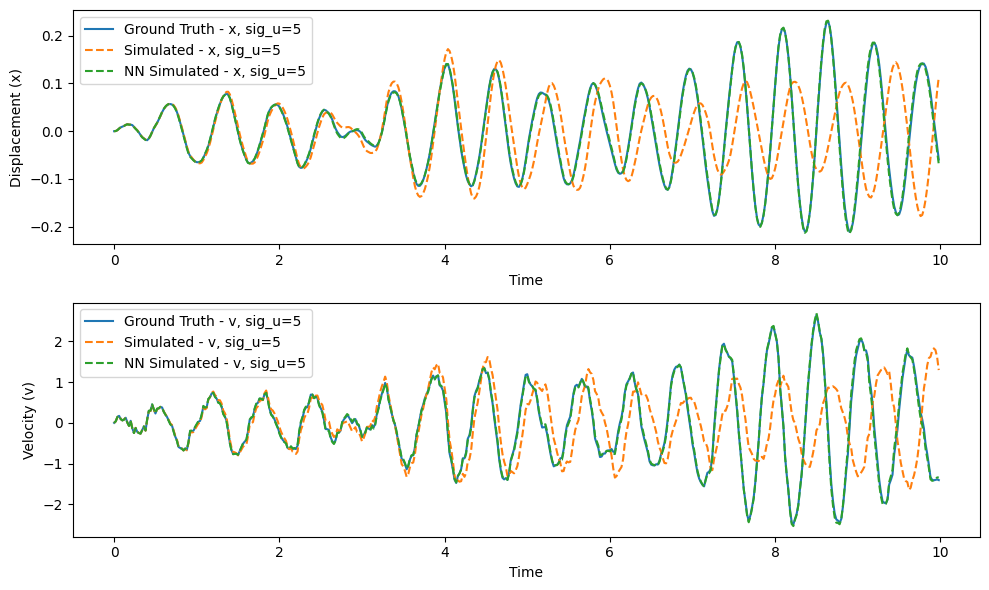

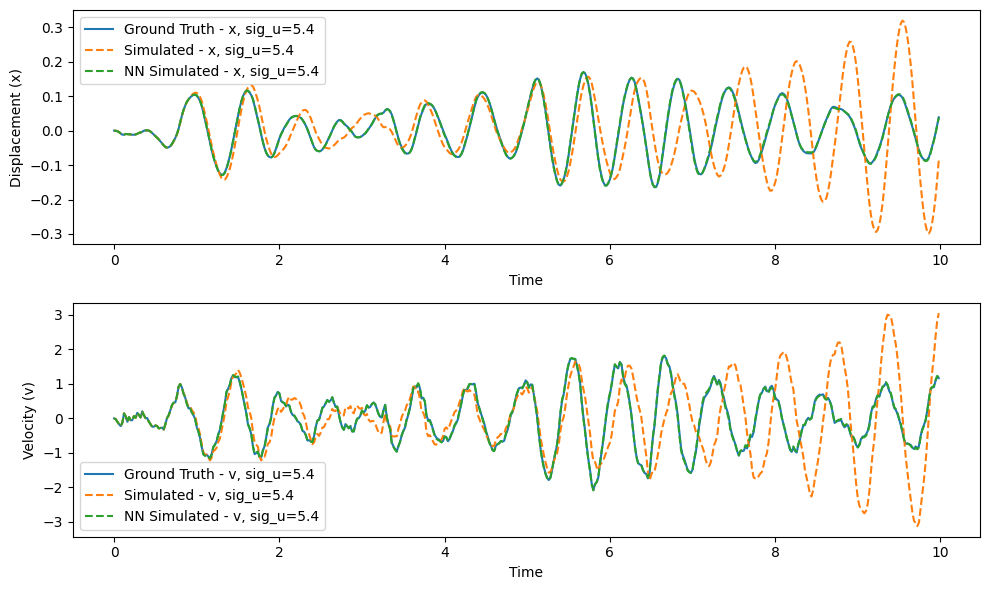

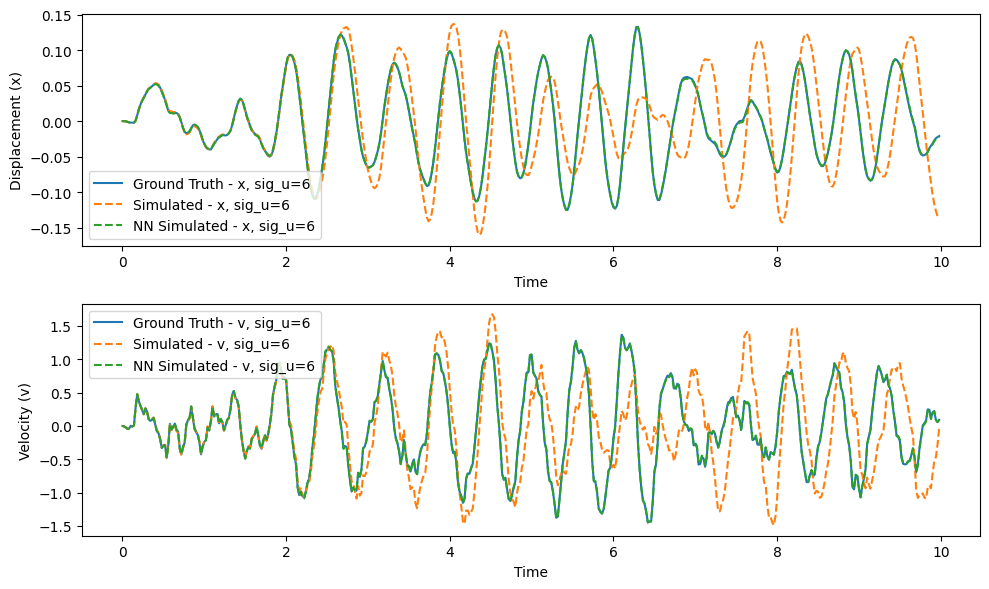

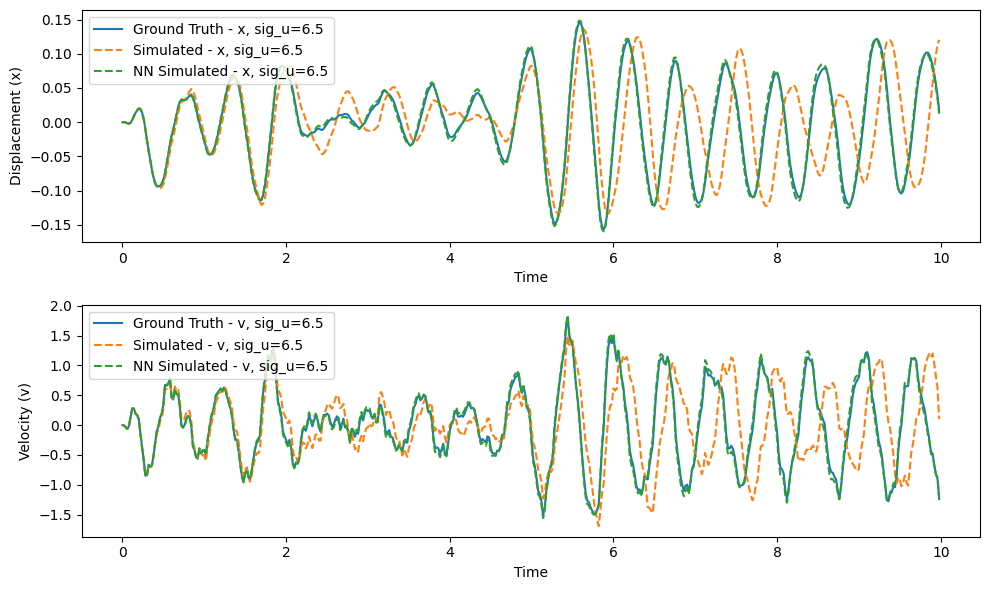

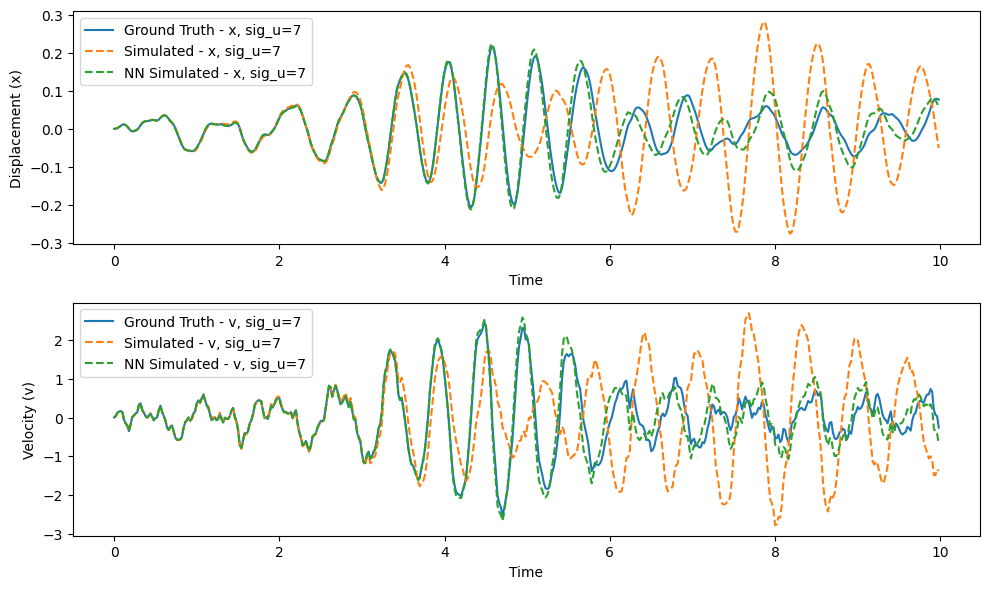

In [37]:
# Plotting
time_values = tspan.squeeze().cpu().numpy()

for i in range(len(sig_u_test)):
    plt.figure(figsize=(10, 6))

    # Plotting Ground Truth and Simulated Data for 'x'
    plt.subplot(2, 1, 1)
    plt.plot(time_values, data_gt_test[:, i, 0], label=f'Ground Truth - x, sig_u={sig_u_test[i]}')
    plt.plot(time_values, data_simulated_test[:, i, 0], label=f'Simulated - x, sig_u={sig_u_test[i]}', linestyle='dashed')
    plt.plot(time_values, data_simulated_NN_test.detach().numpy()[:, i, 0], label=f'NN Simulated - x, sig_u={sig_u_test[i]}', linestyle='dashed')

    plt.xlabel('Time')
    plt.ylabel('Displacement (x)')
    plt.legend()

    # Plotting Ground Truth and Simulated Data for 'v'
    plt.subplot(2, 1, 2)
    plt.plot(time_values, data_gt_test[:, i, 1], label=f'Ground Truth - v, sig_u={sig_u_test[i]}')
    plt.plot(time_values, data_simulated_test[:, i, 1], label=f'Simulated - v, sig_u={sig_u_test[i]}', linestyle='dashed')
    plt.plot(time_values, data_simulated_NN_test.detach().numpy()[:, i, 1], label=f'NN Simulated - v, sig_u={sig_u_test[i]}', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Velocity (v)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [39]:
# Save the parameters of the model
torch.save(model.state_dict(), 'linear_model_epsilon_parameters_m1.pth')